In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.stats import poisson
from astropy.table import QTable, Table, Column
from astropy import units as u
import openpyxl as pyxl
from os import path

Text(0.5, 1.0, 'e.coli/norfloxacin mutation rate')

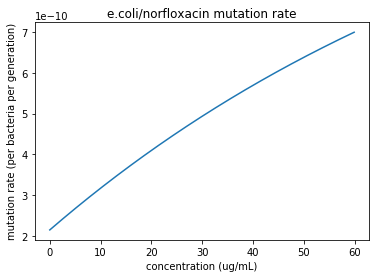

In [4]:
# MUTATION RATE
def mutation_rate(concentration):
    mu_basal = 2.15*10**-10 # basal mutation rate
    m = 6 # max fold increase in mutation rate
    h = 0.01 # steepness of curve
    return mu_basal + (1-np.exp(-h*concentration))*(m-1)*mu_basal
concentrations = np.arange(0,60,0.1)
mutation_rates = [mutation_rate(conc) for conc in concentrations]
plt.plot(concentrations,mutation_rates)
plt.xlabel("concentration (ug/mL)")
plt.ylabel("mutation rate (per bacteria per generation)")
plt.title("e.coli/norfloxacin mutation rate")




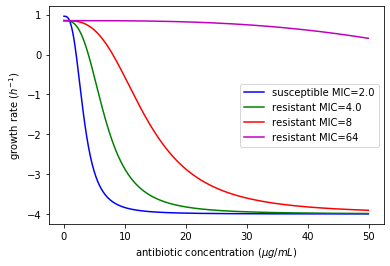

MSC = 0.9473055231097177
k = 3
min growth = -4
max growth susceptible = 0.96
max growth resistant = 0.85


In [5]:
#PARAMETERS FOR AMPICILLIN
MIC = 2.0 # ug/mL
MIC_r1 = 4.0 # ug/mL
MIC_r2 = 8
MIC_r3 = 64
MDK = 3.3 # assumed to be 1 for sus, so must be greater than 1
k = 3
min_growth = -4
max_growth_s = 0.96
max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.85

# k = ufloat(0.75, 0.19)
# min_growth = ufloat(-4.0, 0.8)
# max_growth = ufloat(0.75, 0.21)

def fitness_r1(c):
    return max_growth_r1 - (((max_growth_r1 - min_growth)*((c/MIC_r1)**k))/(((c/MIC_r1)**k)-(min_growth/max_growth_r1)))
def fitness_r2(c):
    return max_growth_r2 - (((max_growth_r2 - min_growth)*((c/MIC_r2)**k))/(((c/MIC_r2)**k)-(min_growth/max_growth_r2)))
def fitness_r3(c):
    return max_growth_r3 - (((max_growth_r3 - min_growth)*((c/MIC_r3)**k))/(((c/MIC_r3)**k)-(min_growth/max_growth_r3)))
def fitness_s(c):
    return max_growth_s - (((max_growth_s - min_growth)*(c/MIC)**k)/(((c/MIC)**k)-(min_growth/max_growth_s)))

concentrations = np.arange(0,50,0.1)
growth_s = [fitness_s(c) for c in concentrations]
growth_r1 = [fitness_r1(c) for c in concentrations]
growth_r2 = [fitness_r2(c) for c in concentrations]
growth_r3 = [fitness_r3(c) for c in concentrations]

plt.figure()
plt.plot(concentrations,growth_s,label='susceptible MIC='+str(MIC) ,color='b')
plt.plot(concentrations,growth_r1,label='resistant MIC='+str(MIC_r1),color='g')
plt.plot(concentrations,growth_r2,label='resistant MIC='+str(MIC_r2),color='r')
plt.plot(concentrations,growth_r3,label='resistant MIC='+str(MIC_r3),color='m')
plt.legend()
plt.xlabel("antibiotic concentration $(\mu g/mL)$")
plt.ylabel("growth rate $(h^{-1})$")
plt.show()

sc = 1 - (max_growth_r1/max_growth_s)
a = 1+(max_growth_r1/-min_growth)
MSC = (sc/(a-(a*(1-sc)/(MIC_r1/MIC)**k)))**(1/k)
print("MSC =",MSC*MIC)

print("k =", k)
print("min growth =", min_growth)
print("max growth susceptible =", max_growth_s)
print("max growth resistant =", max_growth_r1)
# ideal for killing the resistant bacteria quickly is between the MIC and the threshold at which 
# tolerant bacteria become more fit than resistant
# propose a new window of concentrations for ideal killing of resistant bacteria
# for very high concentrations, can run simulations to determine the likelihood
# that tolerant bacteria give rise to resistant bacteria before the antibiotic degrades

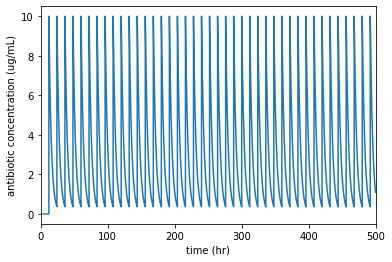

In [6]:
# CONSTANT ANTIBIOTIC CONCENTRATION CONSTANTS WITH PERSISTENCE
# PARAMETERS FOR AMPICILLIN/E.COLI
MIC = 2.0 # ug/mL
MIC_r1 = 4.0 # ug/mL
MIC_r2 = 8
MIC_r3 = 64
k = 0.75
min_growth = -3.5
max_growth_s = 0.96
max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.75

# SIMULATION
T = 500
dt = 0.01
t = np.arange(0,T,dt)
r_initial = 0
s_initial = 10**5
t_initial = 0
p_initial = 0


#ANTIBIOTIC CONCENTRATION PARAMETERS
conc_max = 10 # ug/mL
conc_min = 1 # ug/mL
freq = 12 # hr
growth_period = 12

def conc(t):
    if t < growth_period:
            antibiotic_conc = 0
    else:
        n = t//freq
        decay_rate = -0.27726 #(1/freq)*np.log(conc_min/conc_max)
        antibiotic_conc = conc_max*np.exp(decay_rate*(t-(freq*n)))
    return(antibiotic_conc)

concentration = [conc(time) for time in t]
plt.figure()
plt.plot(t,concentration)
plt.xlabel("time (hr)")
plt.xlim(0,T)
plt.ylabel("antibiotic concentration (ug/mL)")
plt.show()

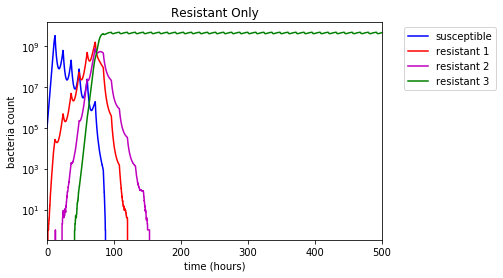

In [7]:
# TOLERANCE AND PERSISTENCE

r1 = [r_initial]*len(t)
r2 = [r_initial]*len(t)
r3 = [r_initial]*len(t)
s = [s_initial]*len(t)
weightedMICs = [0]*len(t)
weightedMaxGrowthRates = [0]*len(t)
totalr = [0]*len(t)
t_lag = 0
K = 5*10**9
mean_sr = [0]*len(t)
mu_sr1 = [0]*len(t)
mu_sr2 = [0]*len(t)
mu_sr3 = [0]*len(t)

mu_basal = 2.15*10**-6

def growth_rate_r1(c):
    return max_growth_r1
def growth_rate_r2(c):
    return max_growth_r2
def growth_rate_r3(c):
    return max_growth_r3
def growth_rate_s(c):
    return max_growth_s 
def death_rate_r1(c):
    return (((max_growth_r1 - min_growth)*((c/MIC_r1)**k))/(((c/MIC_r1)**k)-(min_growth/max_growth_r1)))
def death_rate_r2(c):
    return (((max_growth_r2 - min_growth)*((c/MIC_r2)**k))/(((c/MIC_r2)**k)-(min_growth/max_growth_r2)))
def death_rate_r3(c):
    return (((max_growth_r3 - min_growth)*((c/MIC_r3)**k))/(((c/MIC_r3)**k)-(min_growth/max_growth_r3)))
def death_rate_s(c):
    return (((max_growth_s - min_growth)*(c/MIC)**k)/(((c/MIC)**k)-(min_growth/max_growth_s)))
def mut_frequency(c):
    m = 5 # max fold increase in mutation rate
    h = 2.5 # steepness of curve
    return mu_basal + (1-np.exp(-h*c))*(m-1)*mu_basal
# the mutation frequency increases with antibiotic concentration, but 
# the number of susceptible bacteria also declines, so it's a tradeoff

def simulation(seed):
    np.random.seed(seed)
    for i in range(len(t)-1):
    # 1/generation time
        g_r1 = growth_rate_r1(conc(i*dt)) # must multiply by dt to scale it (not 1,2,3, but 0.1,0.2,0.3, etc)
        d_r1 = death_rate_r1(conc(i*dt))
        g_r2 = growth_rate_r2(conc(i*dt)) # must multiply by dt to scale it (not 1,2,3, but 0.1,0.2,0.3, etc)
        d_r2 = death_rate_r2(conc(i*dt))
        g_r3 = growth_rate_r3(conc(i*dt)) # must multiply by dt to scale it (not 1,2,3, but 0.1,0.2,0.3, etc)
        d_r3 = death_rate_r3(conc(i*dt))
        g_s = growth_rate_s(conc(i*dt))
        d_s = death_rate_s(conc(i*dt))
        totalr[i] = r1[i] + r2[i] + r3[i]
        N = r1[i] + r2[i] + r3[i] + s[i]
        totalMICs = s[i]
        totalMIC1 = r1[i]
        totalMIC2 = r2[i]
        totalMIC3 = r3[i]
        if N>0:
            weightedMIC = (totalMICs/N)*MIC + (totalMIC1/N)*MIC_r1 + (totalMIC2/N)*MIC_r2 + (totalMIC3/N)*MIC_r3
            weightedMaxGrowthRate = ((totalr[i]/N)*max_growth_r1 + (s[i]/N)*max_growth_s)
        else:
            weightedMIC = 0
            weightedMaxGrowthRate = 0
        weightedMICs[i] = weightedMIC
        weightedMaxGrowthRates[i] = weightedMaxGrowthRate
        mean_sr[i] = abs(dt*(mut_frequency(conc(i*dt)))*g_s*(1-N/K))
        mu_sr1[i] = mean_sr[i]*s[i]
        mu_sr2[i] = mean_sr[i]*r1[i]
        mu_sr3[i] = mean_sr[i]*r2[i]
# change in population from regular growth
        if r1[i]*(1-(N/K))*(g_r1*dt) > 0: 
            if r1[i]*(1-(N/K))*(g_r1*dt) - d_r1*r1[i]*dt > -r1[i] and r1[i] >= 1: 
                r1[i+1] = (r1[i] + np.random.poisson(r1[i]*(1-(N/K))*(g_r1*dt)) - np.random.poisson(d_r1*r1[i]*dt))
            else:
                r1[i+1] = 0
        elif d_r1*r1[i]*dt > 0:
            r1[i+1] = r1[i] - np.random.poisson(d_r1*r1[i]*dt)
        else:
            r1[i+1] = r1[i]
        if r2[i]*(1-(N/K))*(g_r2*dt) > 0: 
            if r2[i]*(1-(N/K))*(g_r2*dt) - d_r2*r2[i]*dt > -r2[i] and r2[i] >= 1: 
                r2[i+1] = (r2[i] + np.random.poisson(r2[i]*(1-(N/K))*(g_r2*dt)) - np.random.poisson(d_r2*r2[i]*dt))
            else:
                r2[i+1] = 0
        elif d_r2*r2[i]*dt > 0:
            r2[i+1] = r2[i] - np.random.poisson(d_r2*r2[i]*dt)
        else:
            r2[i+1] = r2[i]
        if r3[i]*(1-(N/K))*(g_r3*dt) > 0: 
            if r3[i]*(1-(N/K))*(g_r3*dt) - d_r3*r3[i]*dt > -r3[i] and r3[i] >= 1: 
                r3[i+1] = (r3[i] + np.random.poisson(r3[i]*(1-(N/K))*(g_r3*dt)) - np.random.poisson(d_r3*r3[i]*dt))
            else:
                r3[i+1] = 0
        elif d_r3*r3[i]*dt > 0:
            r3[i+1] = r3[i] - np.random.poisson(d_r3*r3[i]*dt)
        else:
            r3[i+1] = r3[i]
        if s[i]*(1-(N/K))*(g_s*dt) > 0:
            if (np.random.poisson(s[i]*(1-(N/K))*(g_s*dt)) - np.random.poisson(abs(d_s*s[i]*dt))) > -s[i] and s[i] >= 1:
                s[i+1] = s[i] + np.random.poisson(s[i]*(1-(N/K))*(g_s*dt)) - np.random.poisson(abs(d_s*s[i]*dt))
            else:
                s[i+1] = 0
        elif d_s*s[i]*dt > 0:
            s[i+1] = s[i] - np.random.poisson(d_s*s[i]*dt)
        else:
            s[i+1] = s[i]
# change in population from mutations 
        try:
            s[i+1] -= np.random.poisson(mu_sr1[i])
        except: pass
        try:
            r1[i+1] += (np.random.poisson(mu_sr1[i]))
        except: pass
        try:
            r1[i+1] -= np.random.poisson(mu_sr2[i])
        except: pass
        try:
            r2[i+1] += (np.random.poisson(mu_sr2[i]))
        except: pass
        try:
            r2[i+1] -= np.random.poisson(mu_sr3[i])
        except: pass
        try: 
            r3[i+1] += (np.random.poisson(mu_sr3[i]))
        except: pass
        
# tolerant/persistent bacteria have been shown to have mutation rates 10^4 fold that of susceptible
# Levin Reisman paper showed that tolerance mutations are around 50 times more common than resistant

# solve model
simulation(12)

# plot results
plt.figure()
# plt.plot(t,totalr,label="resistant")
plt.plot(t,s,label="susceptible",color='b',linestyle='solid')
plt.plot(t,r1,label="resistant 1",color='r',linestyle='solid')
plt.plot(t,r2,label="resistant 2",color='m',linestyle='solid')
plt.plot(t,r3,label="resistant 3",color='g',linestyle='solid')
# plt.plot(t,totaltol,label="tolerant")
plt.xlabel('time (hours)')
plt.xlim(0,T)
plt.ylabel('bacteria count')
plt.yscale("log")
plt.legend(bbox_to_anchor=(1.05,1.0),loc='upper left')
plt.title("Resistant Only")
plt.show()

In [8]:
def runAndSave(rawdatasheet, datasheet):
    wb_path = "rbiodatar5.xlsx"
    wb = load_workbook(wb_path)
    for run in range(100):
        send = 0
        r1start = 0
        r1end = 0
        r2start = 0
        r2end = 0
        r3start = 0
        r3end = 0
        
        simulation(run)
        sheet = wb[rawdatasheet]
        print(sheet)
        for time in range(500):
            sheet.cell(row=(run*502)+time+2, column=1, value=run+1)
            sheet.cell(row=(run*502)+time+2, column=2, value=t[time*100])
            sheet.cell(row=(run*502)+time+2, column=3, value=s[time*100])
            if s[time*100]<10 and send==0:
                send = time
            sheet.cell(row=(run*502)+time+2, column=4, value=r1[time*100])
            if r1[time*100]>10 and r1start==0:
                r1start = time
            if r1[time*100]<10 and r1start!=0 and r1end==0:
                r1end = time
            sheet.cell(row=(run*502)+time+2, column=5, value=r2[time*100])
            if r2[time*100]>10 and r2start==0:
                r2start = time
            if r2[time*100]<10 and r2start!=0 and r2end==0:
                r2end = time
            sheet.cell(row=(run*502)+time+2, column=6, value=r3[time*100])
            if r3[time*100]>10 and r3start==0:
                r3start = time
            if r3[time*100]<10 and r3start!=0 and r3end==0:
                r3end = time
            sheet.cell(row=(run*502)+time+2, column=15, value=weightedMICs[time*100])
            sheet.cell(row=(run*502)+time+2, column=17, value=weightedMaxGrowthRates[time*100])

        sheet = wb[datasheet]
        sheet.cell(row=run+2, column=1, value=run+1)
        sheet.cell(row=run+2, column=2, value=send)
        sheet.cell(row=run+2, column=3, value=r1start)
        sheet.cell(row=run+2, column=4, value=r1end)
        sheet.cell(row=run+2, column=5, value=r2start)
        sheet.cell(row=run+2, column=6, value=r2end)
        sheet.cell(row=run+2, column=7, value=r3start)
        sheet.cell(row=run+2, column=8, value=r3end)
        sheet.cell(row=run+2, column=17, value=sum(weightedMICs)/len(weightedMICs))
        sheet.cell(row=run+2, column=19, value=sum(weightedMaxGrowthRates)/len(weightedMaxGrowthRates))
        wb.save(wb_path)

In [9]:
def load_workbook(wb_path):
    if path.exists(wb_path):
        return pyxl.load_workbook(wb_path)
    else:
        return pyxl.Workbook()

def createDataSheets(run):
    wb_path = "rbiodatar5.xlsx"
    wb = load_workbook(wb_path)
    rawsheetname = run+" raw"
    wb.create_sheet(run)
    wb.create_sheet(rawsheetname)
    sheet = wb[rawsheetname]
    bacteriaTypes = [
        (1, "Simulation #"),
        (2, "Time"),
        (3, "Susceptible"),
        (4, "Resistant 1"),
        (5, "Resistant 2"),
        (6, "Resistant 3"),
        (15, "Weighted MIC"),
        (17, "Weighted Max Growth Rate (Fitness)")
    ]

    for col_idx, title in bacteriaTypes:
        sheet.cell(row=1, column=col_idx, value=title)

    sheet = wb[run]
    outputs = [
        (1, "Trial #"),
        (2, "S count > 10 end"),
        (3, "R1 count > 10 start"),
        (4, "R1 count > 10 end"),
        (5, "R2 count > 10 start"),
        (6, "R2 count > 10 end"),
        (7, "R3 count > 10 start"),
        (8, "R3 count > 10 start"),
        (17, "Weighted MIC"),
        (19, "Weighted Fitness")
    ]

    for col_idx, title in outputs:
        sheet.cell(row=1, column=col_idx, value=title)
        
    wb.save(wb_path)

# R

"""
number = "1.11"
createDataSheets(number)
conc_max = 10 # ug/mL
max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.9
mu_basal = 2.15*10**-10
runAndSave(number+" raw", number)

number = "1.12"
createDataSheets(number)
max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.85
runAndSave(number+" raw", number)

number = "1.13"
createDataSheets(number)
max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.8
runAndSave(number+" raw", number)

number = "1.14"
createDataSheets(number)
max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.75
runAndSave(number+" raw", number)

number = "1.15"
createDataSheets(number)
max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.7
runAndSave(number+" raw", number)
"""

# R1

# number = "1.16"
# createDataSheets(number)
# conc_max = 12 # ug/mL
# max_growth_r1 = max_growth_r2 = max_growth_r3 = 0.8
# mu_basal = 2.15*10**-10
# runAndSave(number+" raw", number)

# number = "1.17"
# createDataSheets(number)
# conc_max = 2
# runAndSave(number+" raw", number)

# number = "1.18"
# createDataSheets(number)
# conc_max = 4
# runAndSave(number+" raw", number)

# number = "1.19"
# createDataSheets(number)
# conc_max = 6
# runAndSave(number+" raw", number)

# number = "1.20"
# createDataSheets(number)
# conc_max = 8
# runAndSave(number+" raw", number)

# R2

# number = "1.21"
# createDataSheets(number)
# conc_max = 14
# runAndSave(number+" raw", number)

# number = "1.22"
# createDataSheets(number)
# conc_max = 16
# runAndSave(number+" raw", number)

# number = "1.23"
# createDataSheets(number)
# conc_max = 18
# runAndSave(number+" raw", number)

# number = "1.24"
# createDataSheets(number)
# conc_max = 20
# runAndSave(number+" raw", number)

# R5

number = "1.25"
createDataSheets(number)
conc_max = 0
MIC_r2 = 8
runAndSave(number+" raw", number)

number = "1.26"
createDataSheets(number)
conc_max = 1
runAndSave(number+" raw", number)

number = "1.27"
createDataSheets(number)
conc_max = 3
runAndSave(number+" raw", number)

number = "1.28"
createDataSheets(number)
conc_max = 5
runAndSave(number+" raw", number)

number = "1.29"
createDataSheets(number)
conc_max = 7
runAndSave(number+" raw", number)

# R4

# number = "1.30"
# createDataSheets(number)
# conc_max = 10
# MIC_r2 = 12
# runAndSave(number+" raw", number)

# number = "1.31"
# createDataSheets(number)
# MIC_r2 = 20
# runAndSave(number+" raw", number)

# number = "1.32"
# createDataSheets(number)
# MIC_r2 = 28
# runAndSave(number+" raw", number)

# number = "1.33"
# createDataSheets(number)
# MIC_r2 = 36
# runAndSave(number+" raw", number)

# number = "1.34"
# createDataSheets(number)
# MIC_r2 = 44
# runAndSave(number+" raw", number)

# number = "1.35"
# createDataSheets(number)
# MIC_r2 = 52
# runAndSave(number+" raw", number)

# number = "1.36"
# createDataSheets(number)
# MIC_r2 = 56
# runAndSave(number+" raw", number)

# number = "1.37"
# createDataSheets(number)
# MIC_r2 = 60
# runAndSave(number+" raw", number)




<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet "1.25 raw">
<Worksheet 

<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet "1.28 raw">
<Worksheet 